<a href="https://colab.research.google.com/github/MatheusABomfim/Mest_MBL2_ML_HTLV/blob/main/MEST_HTLV%2BMBL2%2BCLINICAL_Hyperparameters_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Loading data and packages**

**Packages install**

In [1]:
# Att Scikit-learn, imbalanced learn and scikit-optimize
!pip install scikit-learn==1.0.2
!pip install imbalanced-learn
!pip install scikit-optimize

**Libraries import**

In [11]:
# Import necessary libraries and packages
import os
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# sklearn imports
from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedKFold,
    GridSearchCV, RepeatedStratifiedKFold, StratifiedShuffleSplit,
    learning_curve
)
from sklearn.ensemble import (
    ExtraTreesClassifier, RandomForestClassifier,
    AdaBoostClassifier, GradientBoostingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    recall_score, accuracy_score, roc_curve, auc, make_scorer,
    precision_score, f1_score
)
from sklearn.preprocessing import (
    LabelEncoder, MinMaxScaler, MaxAbsScaler, QuantileTransformer,
    RobustScaler, StandardScaler
)
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neural_network import MLPClassifier

# imbalanced-learn imports
from imblearn.metrics import geometric_mean_score
from imblearn.over_sampling import RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN

# joblib imports
from joblib import dump, load

# scikit-optimize imports
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# statsmodels imports
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# openpyxl imports
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows

# ipywidgets imports
from ipywidgets import interact, widgets

# Ignore warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)


**Data import**

In [3]:
# Data selection
cat_data_3k8 = ('/content/drive/MyDrive/Mestrado/Códigos_Bioinfo_e_docs_relacionados(menos_Python_colab)/Results_ML_MBL2_12_01_24/Data sets and Models/df_cat_3_k8_processed.csv')
cat_data_2k8 = ('/content/drive/MyDrive/Mestrado/Códigos_Bioinfo_e_docs_relacionados(menos_Python_colab)/Results_ML_MBL2_12_01_24/Data sets and Models/df_cat_2_k8_processed.csv')
# Defining a global variable to store the DataFrame
df = pd.DataFrame()

# Function to load and process the selected dataset
def load_and_process_data(selected_data):
    global df
    if selected_data == 'Categorização 2 (8 melhores variáveis)':
        df = pd.read_table(cat_data_3k8, sep=',')
    elif selected_data == 'Categorização 3 (8 melhores variáveis)':
        df = pd.read_table(cat_data_2k8, sep=',')
    else:
        df = pd.DataFrame()

    print("Data Loaded and Processed Successfully!")
    return df.head()

# List of dataset options
data_options = ['Categorização 2 (8 melhores variáveis)', 'Categorização 3 (8 melhores variáveis)']

# Selection widget to choose the data set
data_selector = widgets.Dropdown(
    options=data_options,
    description='Select Data:'
)

# Interactive function to load and process the selected data set
@interact(selected_data=data_selector)
def load_and_process_selected_data(selected_data):
    return load_and_process_data(selected_data)


interactive(children=(Dropdown(description='Select Data:', options=('Categorização 2 (8 melhores variáveis)', …

**Data distribution**

In [4]:
y = df['HAM/TSP']  # Target variable
X = df.drop('HAM/TSP', axis=1)  # Predictor variables

# Hyperparametes tuning by bayeasian optimization

**Search for the best hyperparameters and saved definitions**

In [5]:
# Define a random state for reproducibility
RANDOM_STATE = 42

# Ignore warnings
warnings.filterwarnings('ignore')

# Common settings for all models
common_settings = {
    'cv': 5,
    'n_iter': 10,
    'n_jobs': -1,
    'verbose': 0,
}

# Bayesian search function
def bayes_search(model, space):
    bs = BayesSearchCV(
        model, space, n_iter=10,
        cv=RepeatedStratifiedKFold(n_repeats=2, random_state=RANDOM_STATE),
        random_state=RANDOM_STATE,
        scoring=make_scorer(geometric_mean_score)
    )
    return bs

# Model space and hyperparameters
model_space = {
    'DT': {
        'model': DecisionTreeClassifier(random_state=RANDOM_STATE),
        'space': {
            'max_depth': Integer(3, 5),
            'min_samples_split': Integer(5, 10),
            'min_samples_leaf': Integer(1, 5),
            'criterion': Categorical(['gini', 'entropy']),
            'ccp_alpha': Real(0.0, 0.1),
        }
    },
    'GB': {
        'model': GradientBoostingClassifier(random_state=RANDOM_STATE),
        'space': {
            'n_estimators': Integer(50, 500),
            'learning_rate': Real(0.01, 1.0, 'log-uniform'),
            'max_depth': Integer(1, 10),
            'min_samples_split': Integer(2, 20),
            'min_samples_leaf': Integer(1, 20),
            'subsample': Real(0.5, 1.0, 'log-uniform'),
            'loss': Categorical(['deviance', 'exponential']),
        }
    },
    'LR': {
        'model': LogisticRegression(random_state=RANDOM_STATE),
        'space': {
            'C': Real(0.0001, 1000, 'log-uniform'),
            'max_iter': Integer(200, 2000),
            'solver': Categorical(['liblinear', 'sag', 'saga']),
            'class_weight': Categorical(['balanced', None]),
            'tol': Real(0.0001, 0.001),
        }
    },
    'MLP': {
        'model': MLPClassifier(random_state=RANDOM_STATE),
        'space': {
            'hidden_layer_sizes': Integer(2, 16),
            'activation': Categorical(['logistic', 'tanh', 'relu']),
            'learning_rate': Categorical(['constant', 'adaptive']),
            'learning_rate_init': Real(0.001, 0.1, 'log-uniform'),
            'max_iter': Integer(200, 2000),
            'solver': Categorical(['sgd', 'adam']),
            'momentum': Real(0.1, 0.9, 'log-uniform'),
        }
    },
    'NB': {
        'model': GaussianNB(),
        'space': {
        }
    },
    'RF': {
        'model': RandomForestClassifier(random_state=RANDOM_STATE),
        'space': {
            'n_estimators': Integer(50, 500),
            'max_depth': Integer(3, 10),
            'min_samples_split': Integer(2, 10),
            'min_samples_leaf': Integer(1, 5),
            'criterion': Categorical(['gini', 'entropy']),
            'max_samples': Real(0.5, 1.0, 'log-uniform'),
            'class_weight': Categorical(['balanced', 'balanced_subsample']),
        }
    },
    'SVM': {
        'model': SVC(probability=True, random_state=RANDOM_STATE),
        'space': {
            'kernel': Categorical(['linear', 'poly', 'rbf', 'sigmoid']),
            'gamma': Real(0.001, 1000),
            'degree': Integer(2, 5),
            'coef0': Real(0.0001, 1, 'log-uniform'),
            'C': Real(0.001, 1000),
            'tol': Real(0.00001, 0.1, 'log-uniform'),
            'max_iter': Integer(200, 2000),
            'class_weight': Categorical([None, 'balanced']),
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'space': {
            'n_neighbors': Integer(1, 20),
            'weights': Categorical(['uniform', 'distance']),
            'algorithm': Categorical(['auto', 'ball_tree', 'kd_tree', 'brute']),
            'leaf_size': Integer(20, 50),
            'p': Integer(1, 2),
        }
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(random_state=RANDOM_STATE),
        'space': {
            'n_estimators': Integer(50, 500),
            'learning_rate': Real(0.01, 1.0, 'log-uniform'),
        }
    },
    'LSVM': {
        'model': LinearSVC(random_state=RANDOM_STATE),
        'space': {
            'C': Real(0.0001, 1000, 'log-uniform'),
            'tol': Real(0.00001, 0.1, 'log-uniform'),
            'max_iter': Integer(200, 2000),
            'class_weight': Categorical([None, 'balanced']),
        }
    },
}

# Template saving directory
save_dir = '/content/drive/MyDrive/Mestrado/Códigos_Bioinfo_e_docs_relacionados(menos_Python_colab)/Pós-qualificação/Modelos otimizados'

# Iterating over the models in the search space
for model_name in model_space:
    model = model_space[model_name]['model']
    space = model_space[model_name]['space']

    # Check that the search space is not empty
    if space:
        bs = bayes_search(model, space)
        bs.fit(X, y)

        print(f'Model: {model_name}')
        print(f'Melhor score: {bs.best_score_}')
        print(f'Melhores parâmetros: {bs.best_params_}')

        # Saving the best model
        model_path = os.path.join(save_dir, f'best_{model_name}_model.joblib')
        dump(bs.best_estimator_, model_path)

    else:
        # Train the model directly if there are no hyperparameters to adjust
        model.fit(X, y)
        print(f'Model: {model_name}')
        print('Modelo treinado diretamente sem busca Bayesiana.')

        # Saving the trained model
        model_path = os.path.join(save_dir, f'best_{model_name}_model.joblib')
        dump(model, model_path)


Model: DT
Melhor score: 0.8969996962540593
Melhores parâmetros: OrderedDict([('ccp_alpha', 0.04101039588533139), ('criterion', 'entropy'), ('max_depth', 5), ('min_samples_leaf', 2), ('min_samples_split', 8)])
Model: GB
Melhor score: 0.9245927693274204
Melhores parâmetros: OrderedDict([('learning_rate', 0.42149456283334996), ('loss', 'deviance'), ('max_depth', 6), ('min_samples_leaf', 16), ('min_samples_split', 11), ('n_estimators', 93), ('subsample', 0.8442841485409516)])
Model: LR
Melhor score: 0.8868321244620596
Melhores parâmetros: OrderedDict([('C', 0.00010602594470834996), ('class_weight', None), ('max_iter', 1534), ('solver', 'liblinear'), ('tol', 0.0006207979026055464)])
Model: MLP
Melhor score: 0.9128528844563123
Melhores parâmetros: OrderedDict([('activation', 'tanh'), ('hidden_layer_sizes', 13), ('learning_rate', 'constant'), ('learning_rate_init', 0.056059676937961246), ('max_iter', 1267), ('momentum', 0.3693275579721808), ('solver', 'adam')])
Model: NB
Modelo treinado diret

**Load the definitions identified for the models**

In [6]:
# Lista dos nomes dos modelos que foram ajustados
model_names = ['DT', 'GB', 'LR', 'MLP', 'NB', 'RF', 'SVM', 'KNN', 'AdaBoost', 'LSVM']

# Lista dos nomes dos modelos para corresponder aos model_names
names = [
    'Decision Tree',
    'Gradient Boosting',
    'Logistic Regression',
    'Neural Network',
    'Naive Bayes',
    'Random Forest',
    'SVM',
    'Nearest Neighbors',
    'AdaBoost',
    'Linear DA',
]

# Diretório onde os modelos e resultados estão salvos
model_dir = '/content/drive/MyDrive/Mestrado/Códigos_Bioinfo_e_docs_relacionados(menos_Python_colab)/Pós-qualificação/Modelos otimizados/cat_3K8'

# Lista para armazenar os modelos carregados
classifiers = []

# Função para carregar modelos
def load_model(model_name):
    model_path = os.path.join(model_dir, f'best_{model_name}_model.joblib')

    if os.path.exists(model_path):
        # Carregar o modelo
        model = load(model_path)

        # Adicionar o modelo à lista de classifiers
        classifiers.append(model)

        print(f'Modelo {model_name} carregado com sucesso.')
    else:
        print(f'Arquivo para o modelo {model_name} não encontrado.')

# Iterar sobre todos os nomes de modelos e carregá-los
for model_name in model_names:
    load_model(model_name)


Modelo DT carregado com sucesso.
Modelo GB carregado com sucesso.
Modelo LR carregado com sucesso.
Modelo MLP carregado com sucesso.
Modelo NB carregado com sucesso.
Modelo RF carregado com sucesso.
Modelo SVM carregado com sucesso.
Modelo KNN carregado com sucesso.
Modelo AdaBoost carregado com sucesso.
Modelo LSVM carregado com sucesso.


#**Evaluation of optimized models**




**F1-metrics + ROC Curve + Mean AUC for optimized hyperparameters**




Teste do modelo Decision Tree em execução
Teste do modelo Gradient Boosting em execução
Teste do modelo Logistic Regression em execução
Teste do modelo Neural Network em execução
Teste do modelo Naive Bayes em execução
Teste do modelo Random Forest em execução
Teste do modelo SVM em execução
Teste do modelo Nearest Neighbors em execução
Teste do modelo AdaBoost em execução
Teste do modelo Linear DA em execução


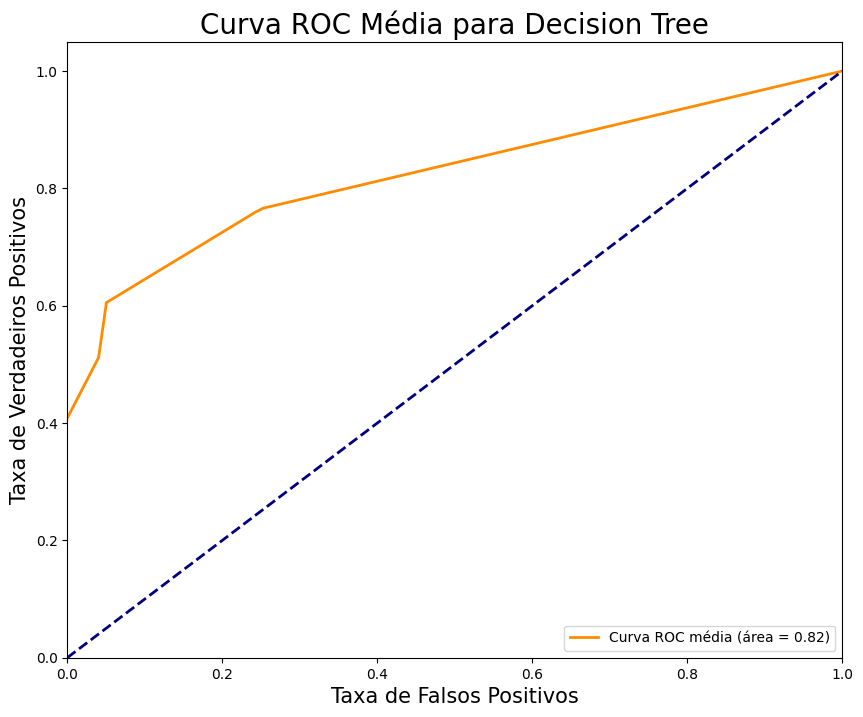

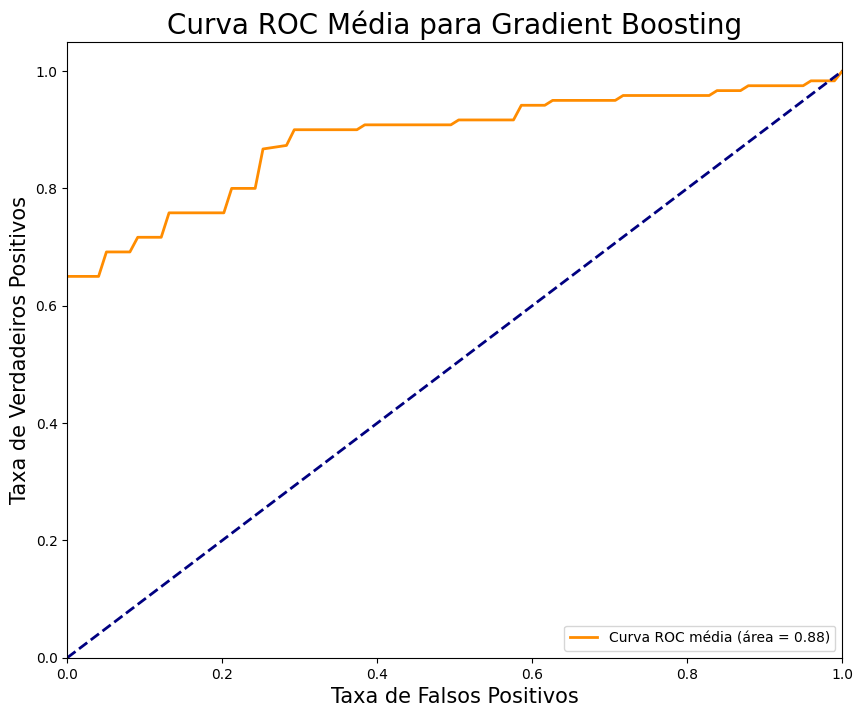

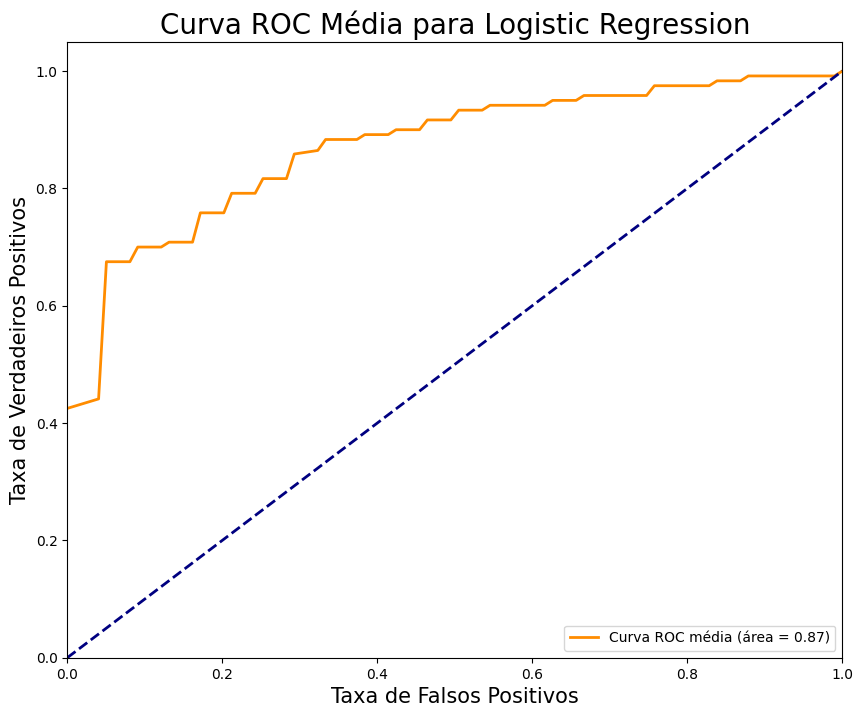

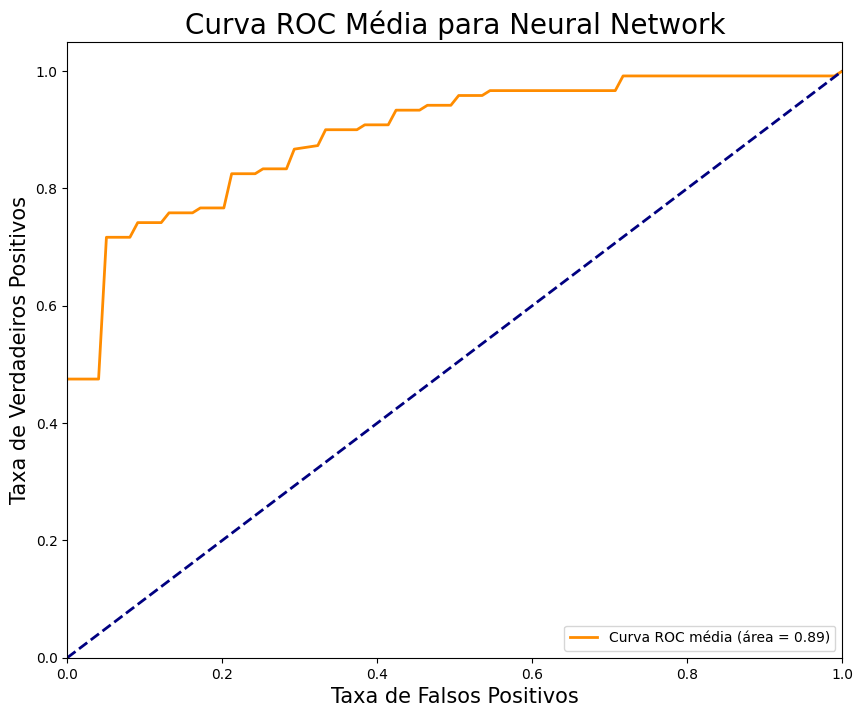

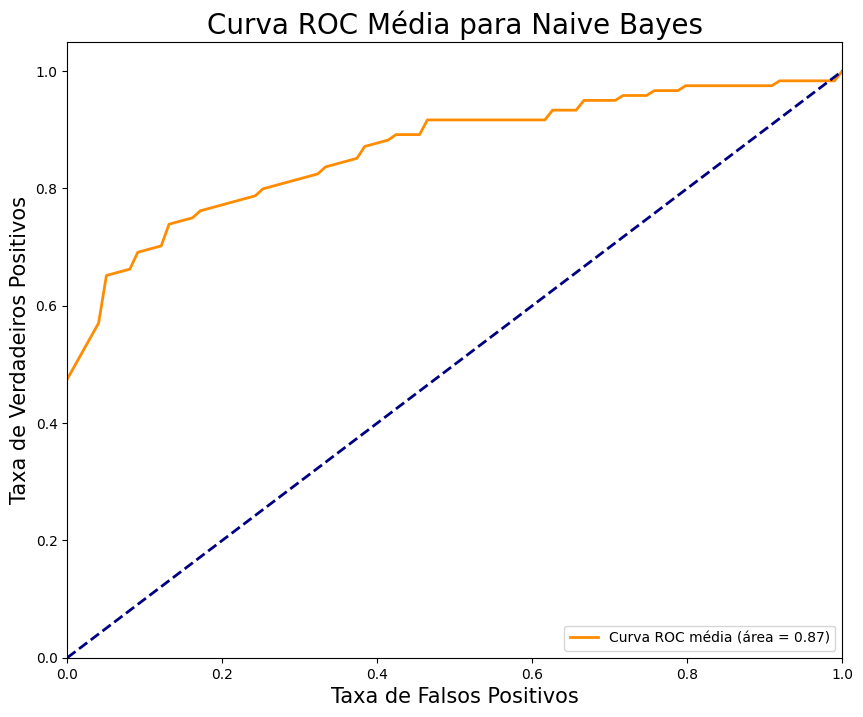

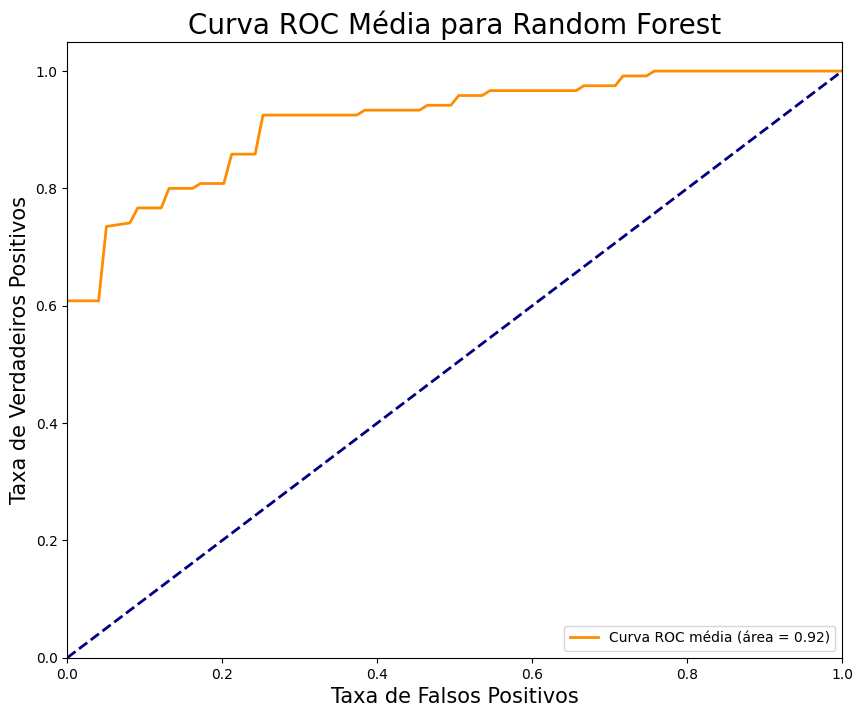

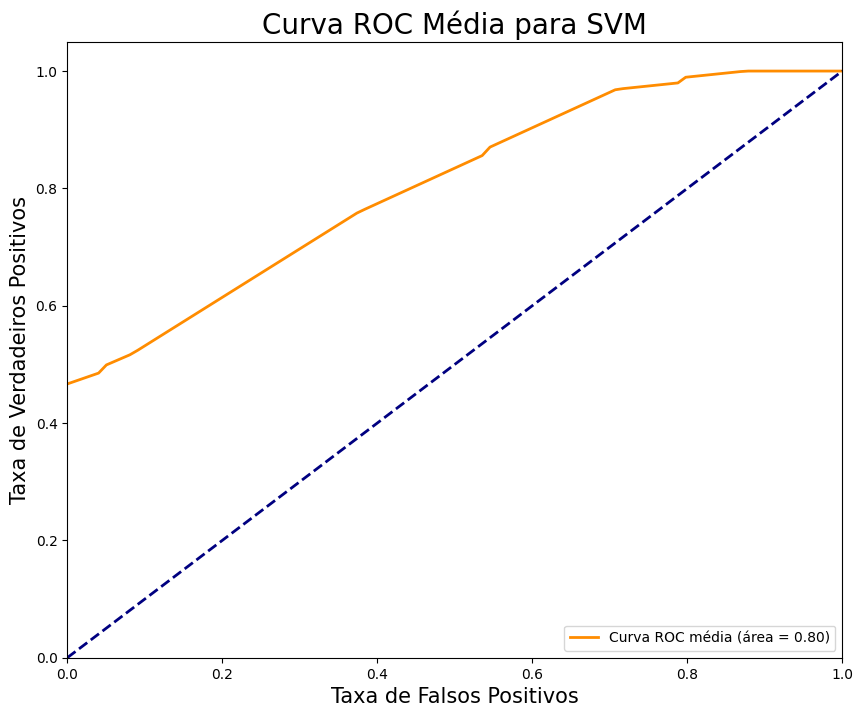

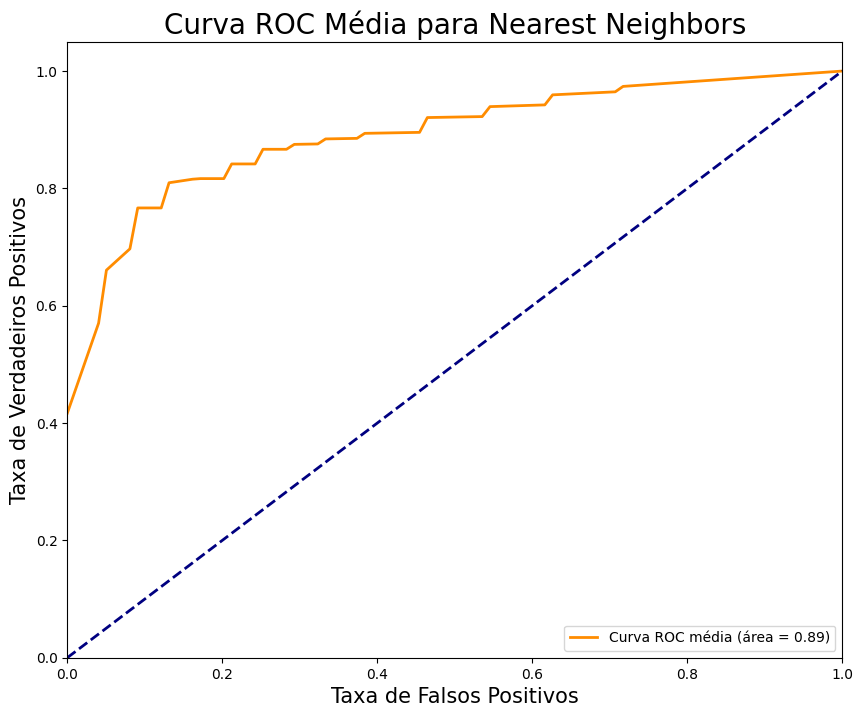

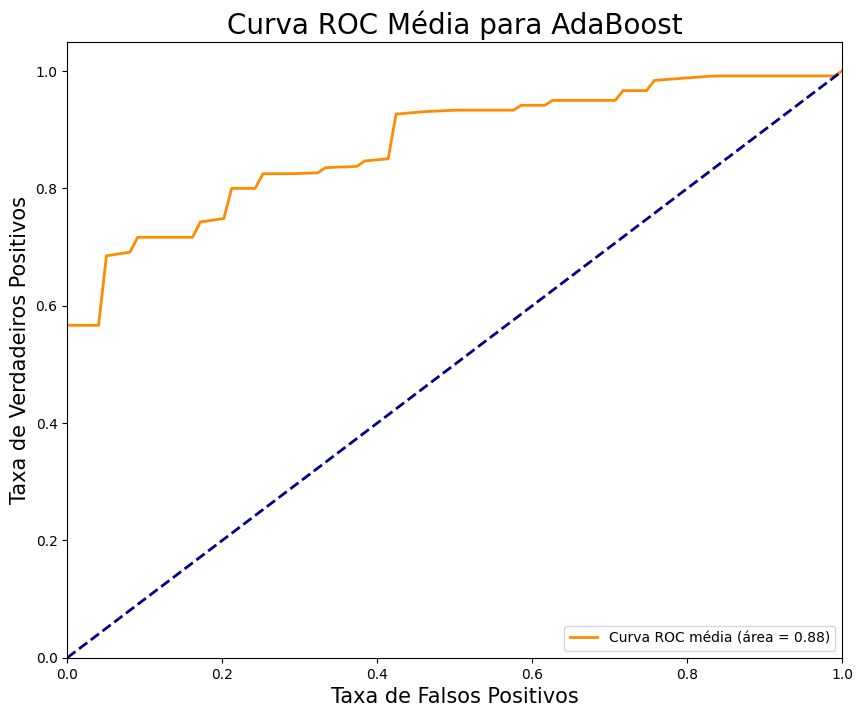

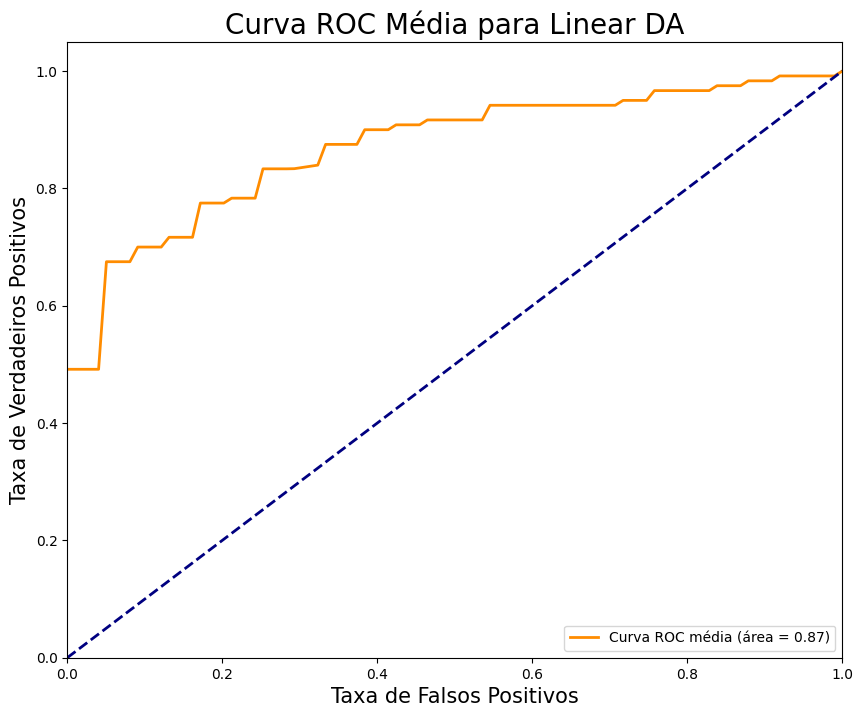

In [8]:
# Number of folds
k_folds = 5

# Clearing old data from the data_table, if the code has been run previously
data_table = pd.DataFrame()
f1_m = []

for item, nome in zip(classifiers, names):
    # Lists to store the resampled training data
    X_train_resampled_list = []
    y_train_resampled_list = []

    # Create an instance of SMOTEENN
    smote_enn = SMOTEENN(random_state=42)
    skf = StratifiedKFold(n_splits=k_folds)

    # Lists to store ROC curves data
    all_fpr = []
    all_tpr = []
    all_roc_auc = []

    # Apply Stratified K-Fold to the original data
    for train_index, test_index in skf.split(X, y):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        # Apply SMOTEENN to the training fold
        X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_fold, y_train_fold)

        # Train the classifier on the resampled training data
        item.fit(X_train_resampled, y_train_resampled)

        # Make predictions on the test fold
        if hasattr(item, 'predict_proba'):
            y_pred_proba = item.predict_proba(X_test_fold)[:, 1]
        else:
            y_pred_proba = item.decision_function(X_test_fold)
            # Aplica a função sigmoid para converter em probabilidades
            y_pred_proba = 1 / (1 + np.exp(-y_pred_proba))

        # Store the true labels and predicted probabilities
        y_test_all = y_test_fold
        y_pred_proba_all = y_pred_proba

        # Calculate ROC curve and AUC for this fold
        fpr, tpr, _ = roc_curve(y_test_all, y_pred_proba_all)
        roc_auc = auc(fpr, tpr)

        all_fpr.append(fpr)
        all_tpr.append(tpr)
        all_roc_auc.append(roc_auc)

    # Calculate mean ROC curve
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean([np.interp(mean_fpr, f, t) for f, t in zip(all_fpr, all_tpr)], axis=0)
    mean_roc_auc = auc(mean_fpr, mean_tpr)

    plt.figure(figsize=(10, 8))
    plt.plot(mean_fpr, mean_tpr, color='darkorange', lw=2, label=f'Curva ROC média (área = {mean_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos', fontsize=15)
    plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=15)
    plt.title(f'Curva ROC Média para {nome}', fontsize=20)
    plt.legend(loc="lower right")
    plt.savefig('/content/drive/MyDrive/Mestrado/Códigos_Bioinfo_e_docs_relacionados(menos_Python_colab)/Pós-qualificação/ROC Curve/' + 'Curva ROC Média ' + nome + '.jpeg')

    # Calculation and print of F1 and associated metrics
    precision_mean_score = cross_val_score(item, X, y, scoring="precision", cv=k_folds).mean()
    std_score = cross_val_score(item, X, y, scoring="precision", cv=k_folds).std()
    accuracy_mean_score = cross_val_score(item, X, y, scoring="accuracy", cv=k_folds).mean()
    recall_mean_score = cross_val_score(item, X, y, scoring="recall", cv=k_folds).mean()
    f1_mean_score = cross_val_score(item, X, y, scoring="f1", cv=k_folds).mean()

    print(f"Teste do modelo {nome} em execução")

    # Creating the data frames that values to be saved
    results_mean_precision = pd.DataFrame({'Precision Mean': [precision_mean_score]})
    results_mean_accuracy = pd.DataFrame({'Accuracy Mean': [accuracy_mean_score]})
    results_mean_recall = pd.DataFrame({'Recall Mean': [recall_mean_score]})
    results_mean_f1 = pd.DataFrame({'F1 Mean': [f1_mean_score]})

    # Creating the data frames (with the values of interest) that will be plotted in text file
    f1_metrics = pd.DataFrame(
    [{
        "Nome": nome,
        "Accuracy": results_mean_accuracy.iloc[0]['Accuracy Mean'],
        "Recall": results_mean_recall.iloc[0]['Recall Mean'],
        "Precision": results_mean_precision.iloc[0]['Precision Mean'],
        "F1 Score": results_mean_f1.iloc[0]['F1 Mean'],
    }]
)
    f1_m.append(f1_metrics)
    data_table = pd.concat(f1_m, ignore_index=True)
data_table = np.round(data_table.reset_index(drop=True), 2)

# Aesthetic transformation similar to a heatmap
styled_table = data_table.sort_values(by='Accuracy', ascending=False)\
      .style.background_gradient(cmap='coolwarm')\
      .bar(subset=['Recall'], color='#ff355d')\
      .bar(subset=['Precision'], color='lightseagreen')\
      .bar(subset=['F1 Score'], color='gold')

# Save the generated excel file (optional)
styled_table.to_excel('/content/drive/MyDrive/Mestrado/Códigos_Bioinfo_e_docs_relacionados(menos_Python_colab)/Pós-qualificação/F1 Metrics/Modelos otimizados/F1_Metrics.xlsx', engine='openpyxl')


**Learning Curves**

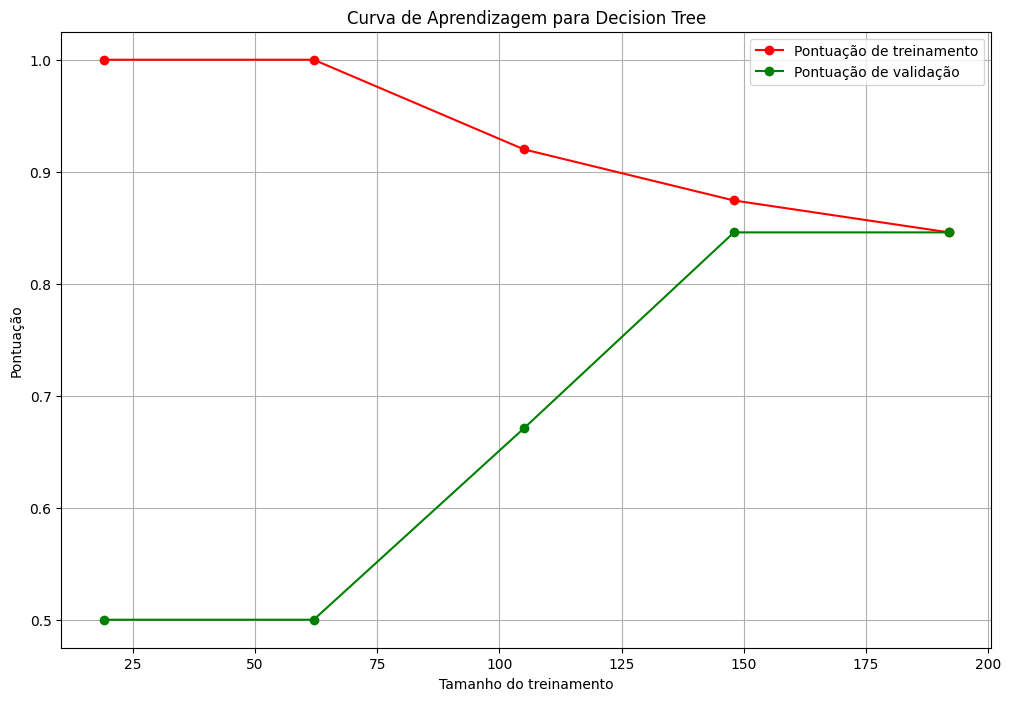

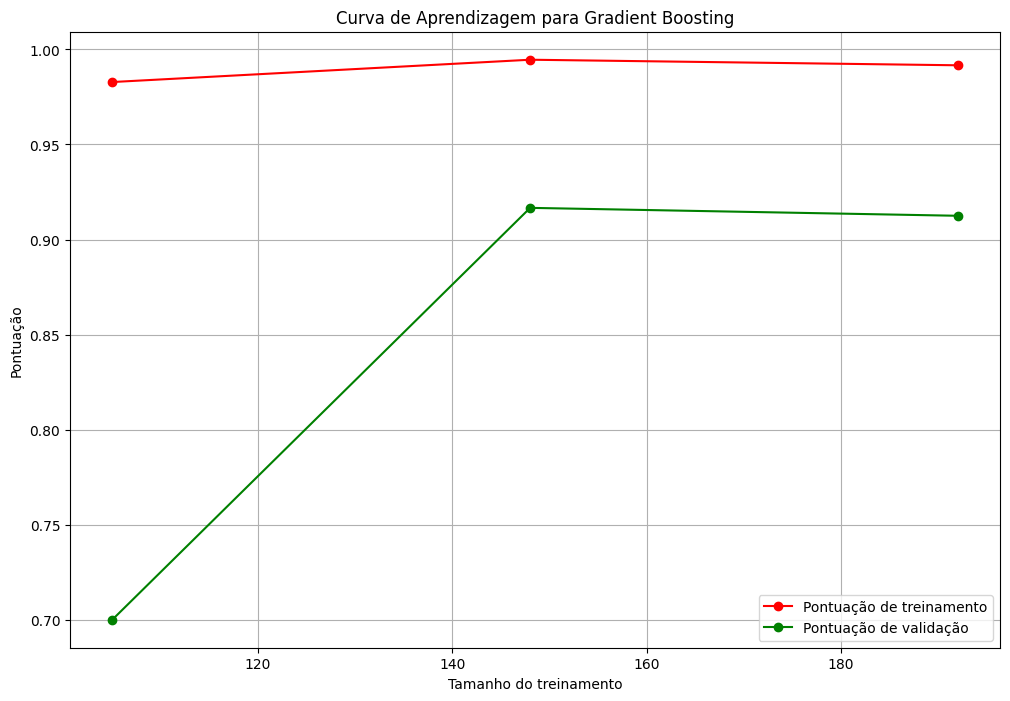

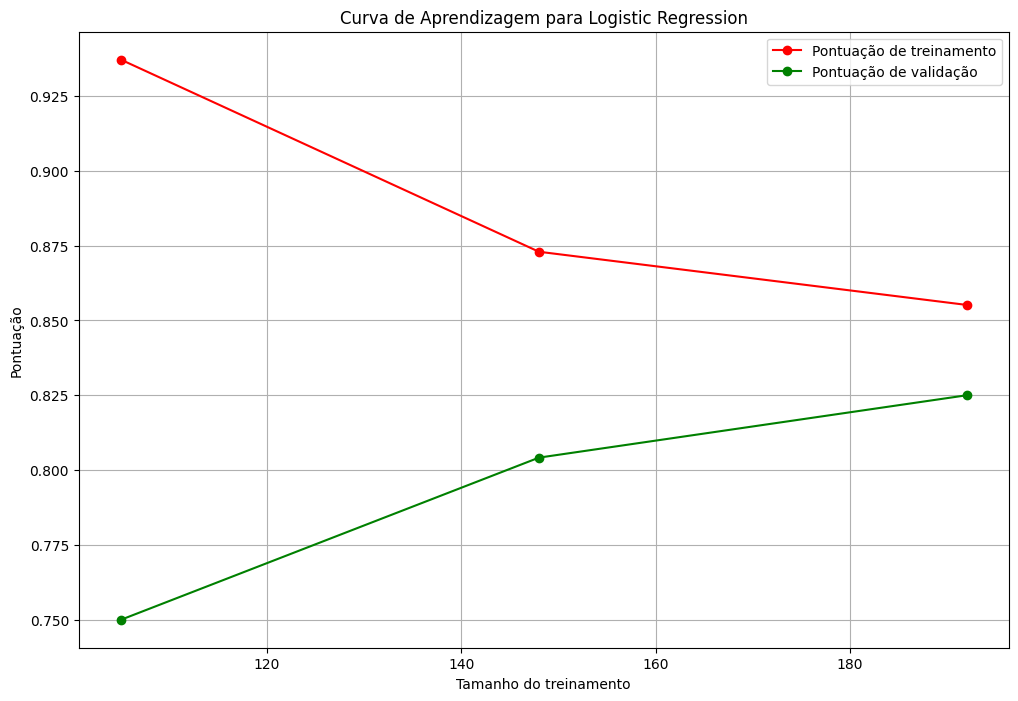

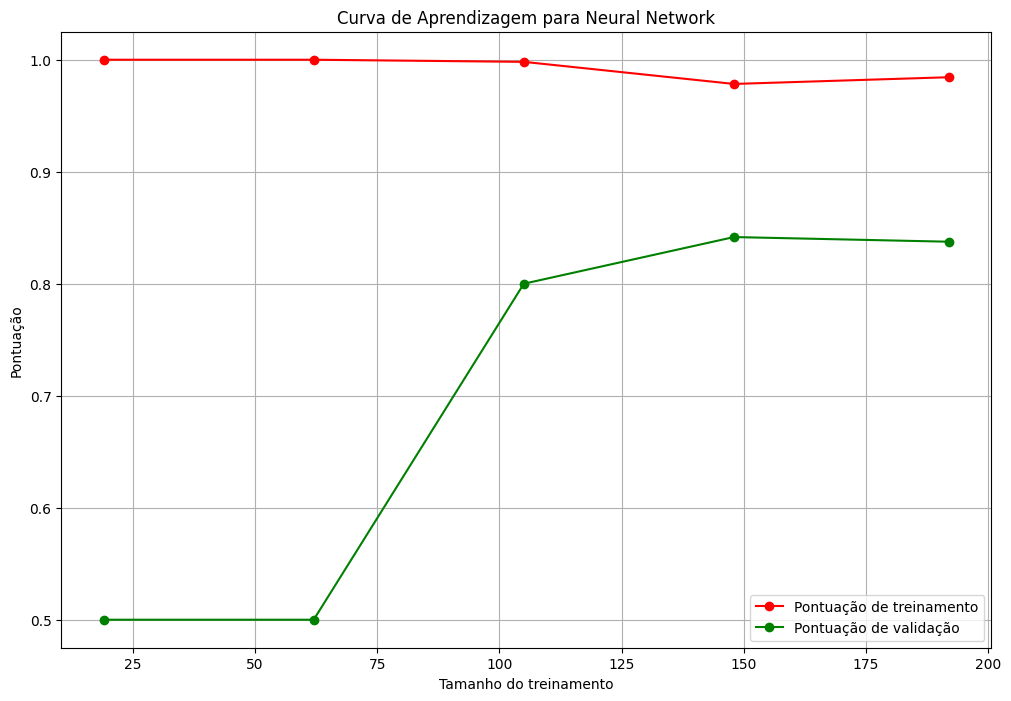

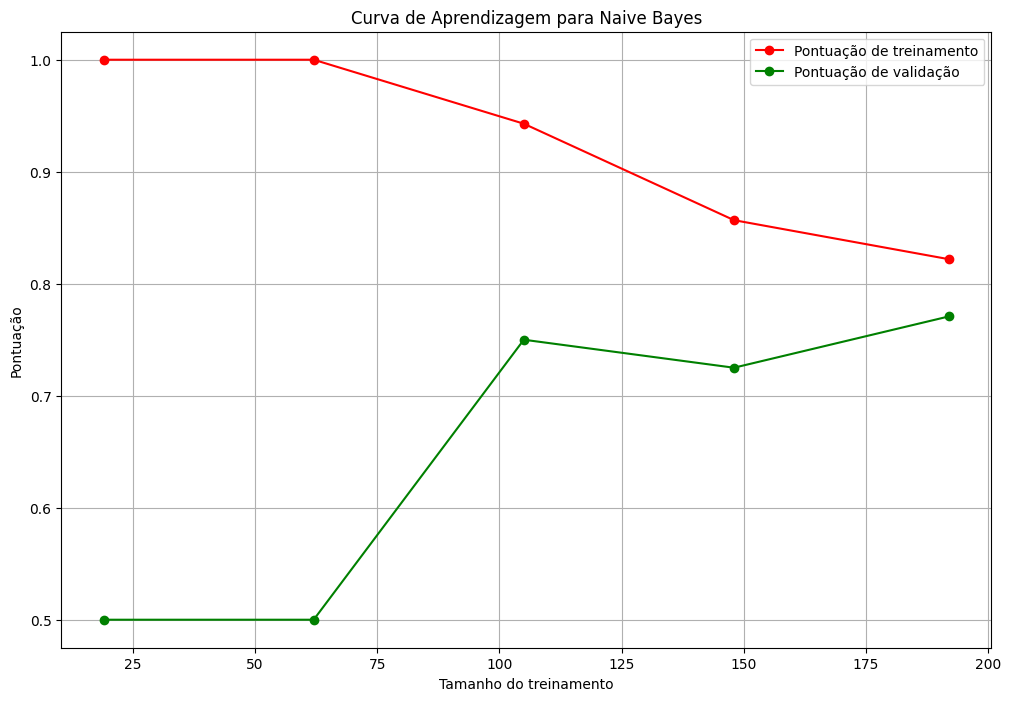

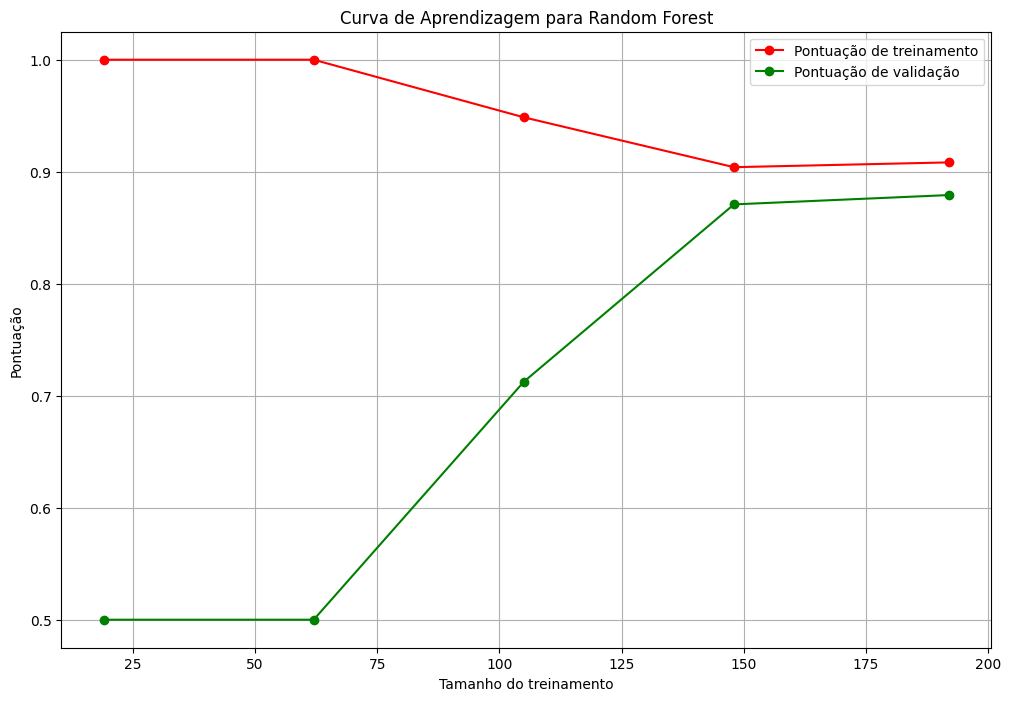

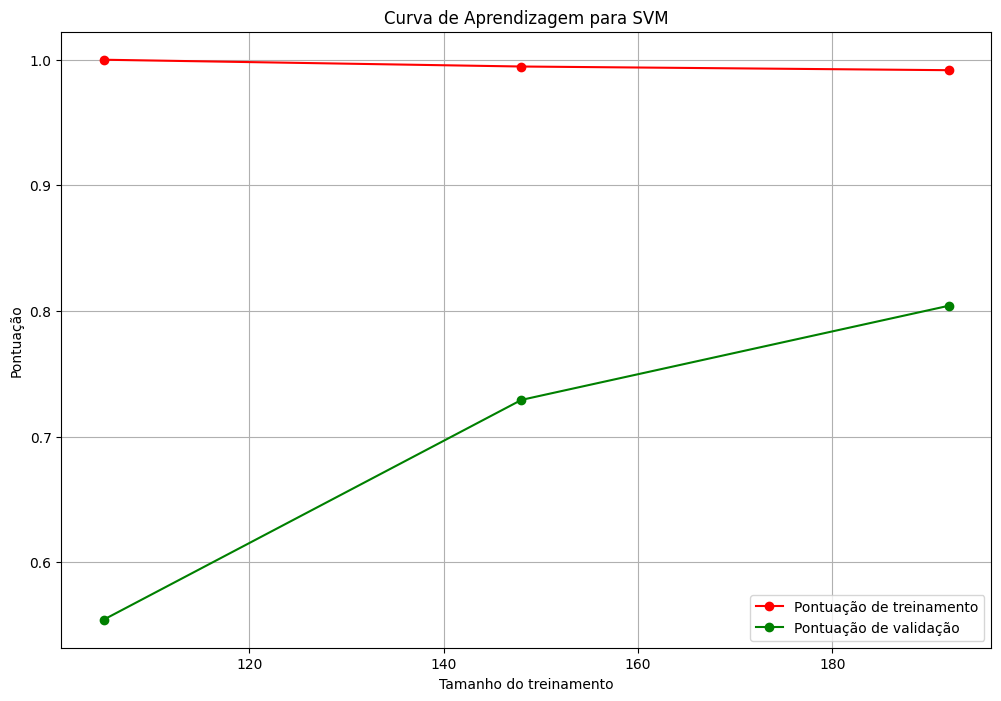

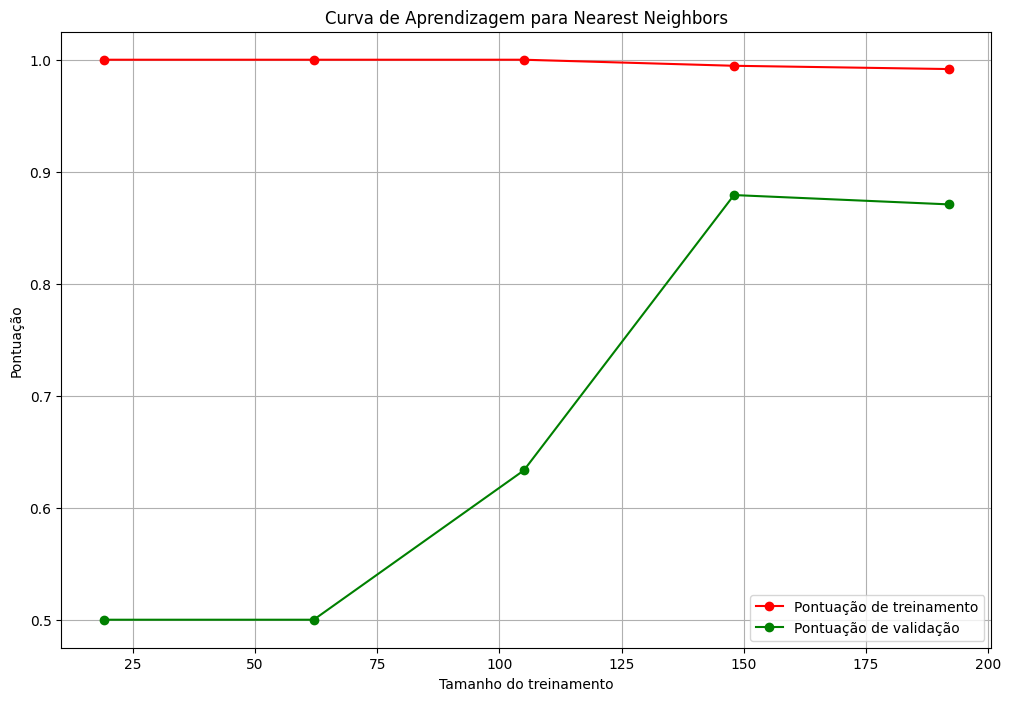

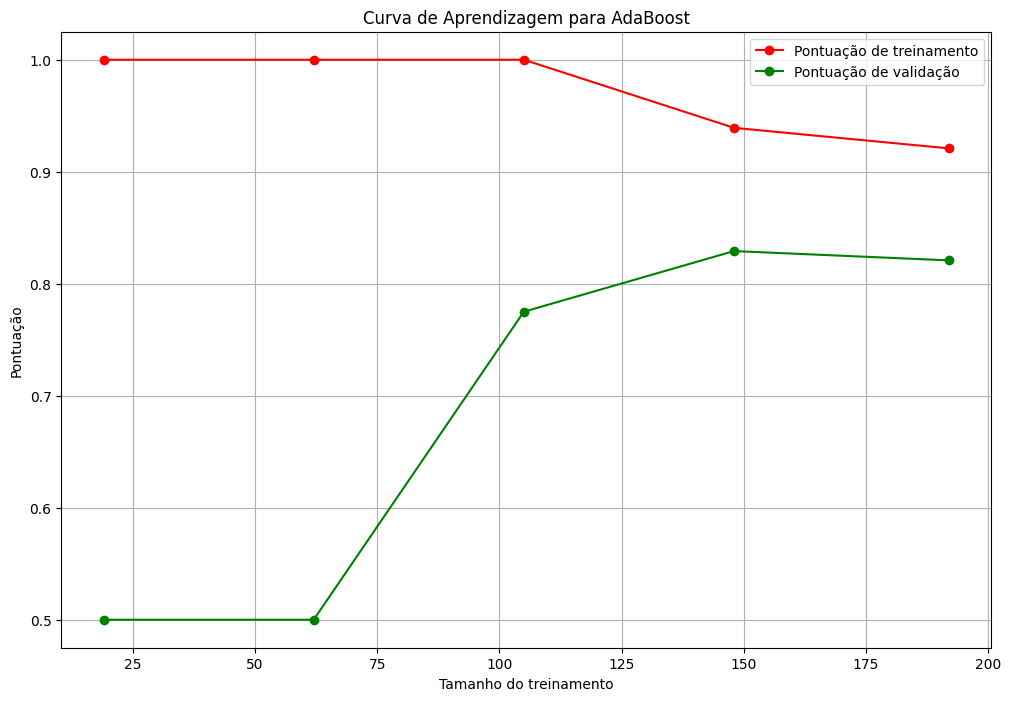

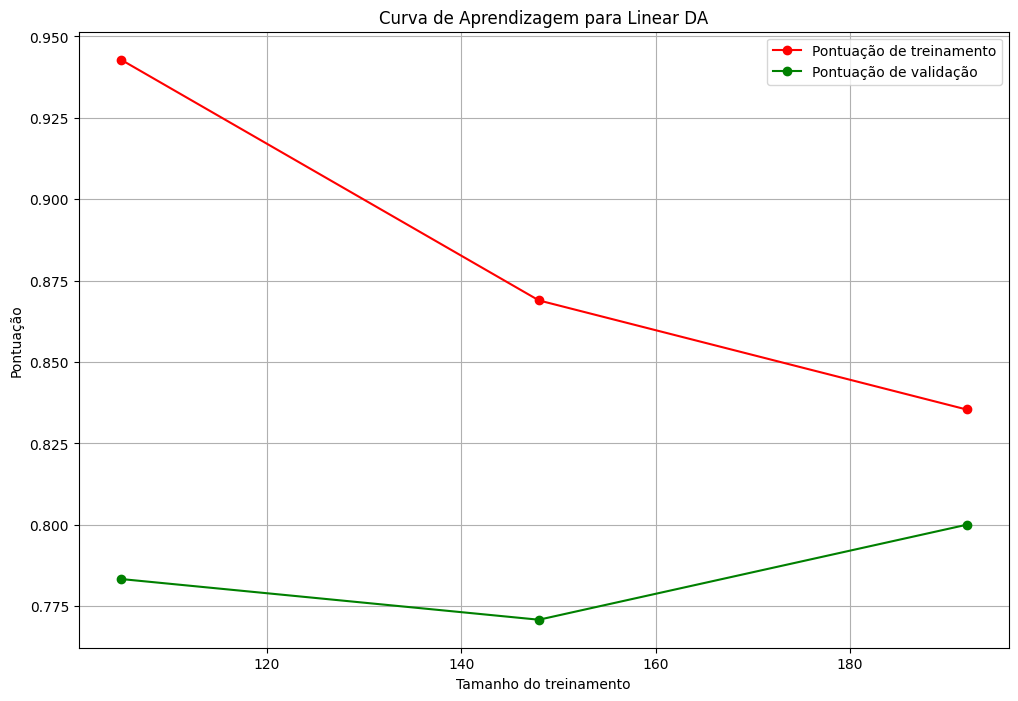

In [9]:
# Iterate over each classifier and plot the learning curve
for item, nome in zip(classifiers, names):
    plt.figure(figsize=(12, 8))
    plt.title(f'Curva de Aprendizagem para {nome}')
    plt.xlabel("Tamanho do treinamento")
    plt.ylabel("Pontuação")

    # Use Stratified K-fold to calculate training and validation scores
    train_sizes, train_scores, test_scores = learning_curve(item, X, y, cv=skf, train_sizes=np.linspace(.1, 1.0, 5))

    # Calculate the averages and standard deviations of the training and validation scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot the learning curves with confidence interval
    plt.grid()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Pontuação de treinamento")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Pontuação de validação")
    plt.legend(loc="best")
    plt.savefig(f'/content/drive/MyDrive/Mestrado/Códigos_Bioinfo_e_docs_relacionados(menos_Python_colab)/Pós-qualificação/Learning curve/Modelos otimizados/Learning_curve_{nome}.jpeg')
    plt.show()


**Confunsion matrix**

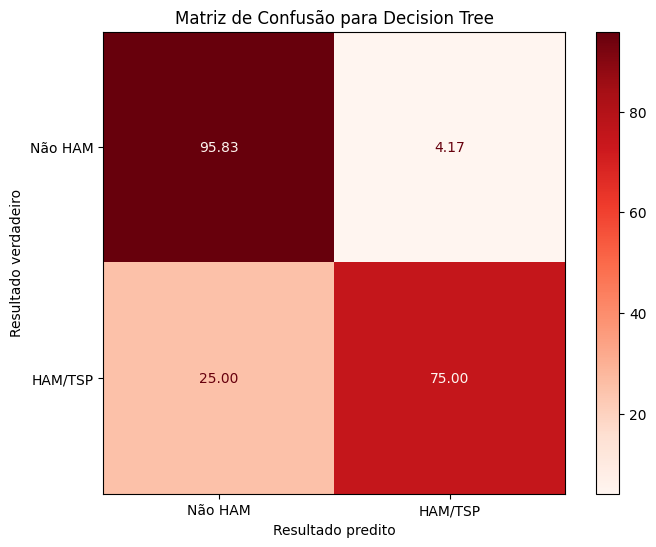

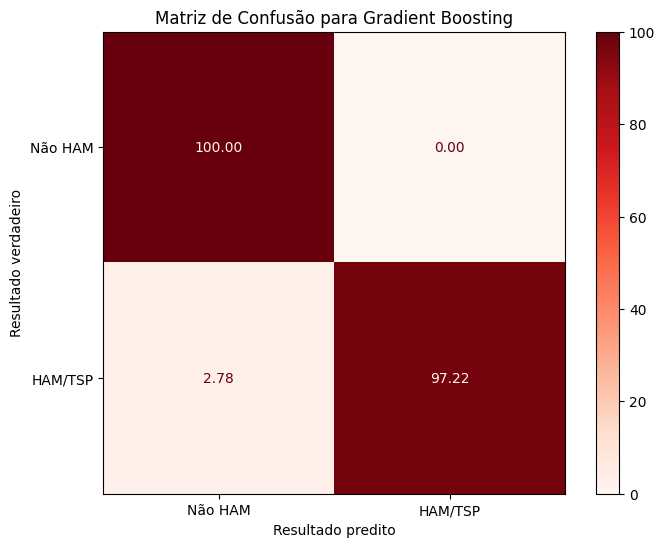

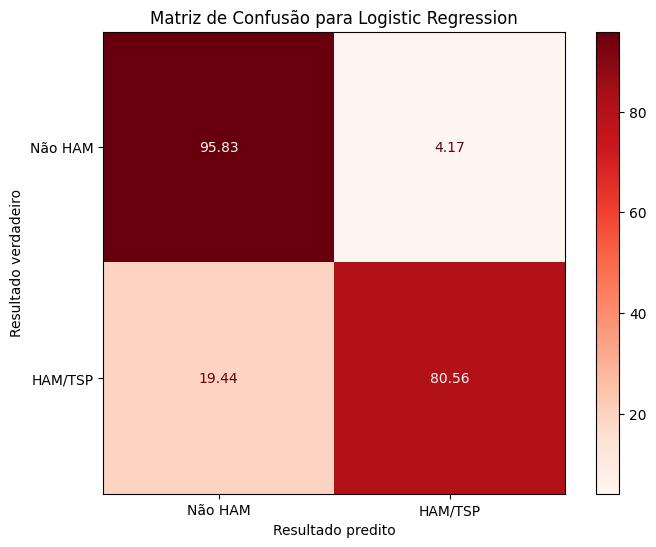

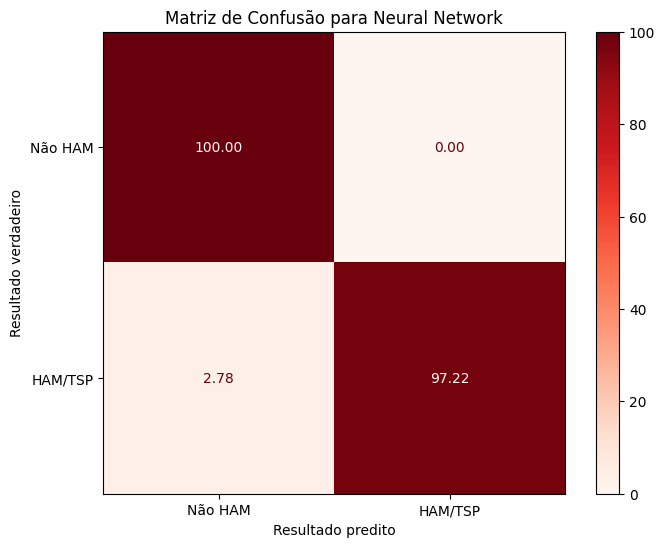

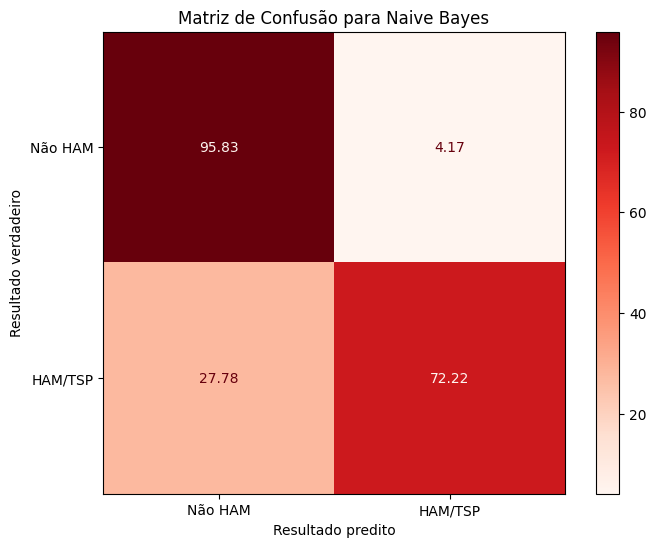

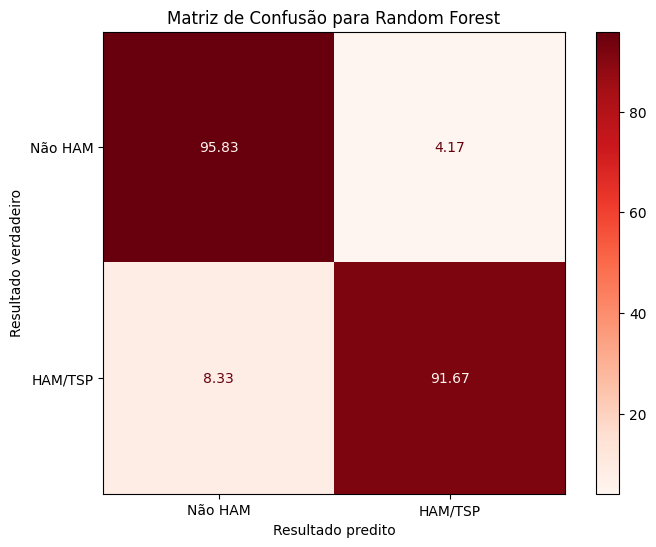

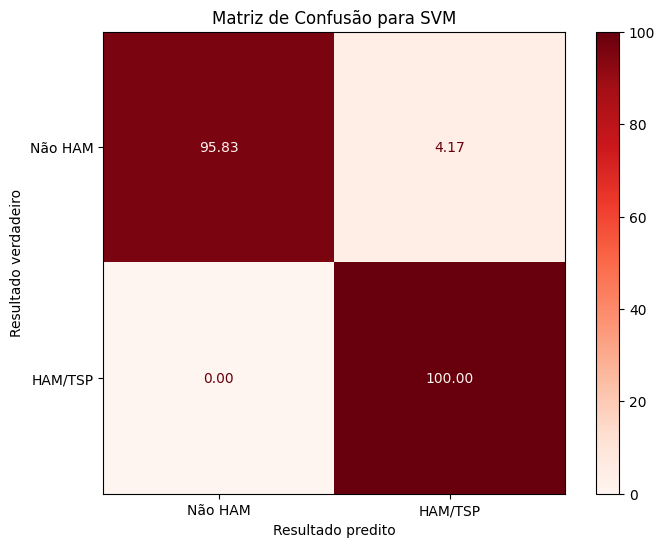

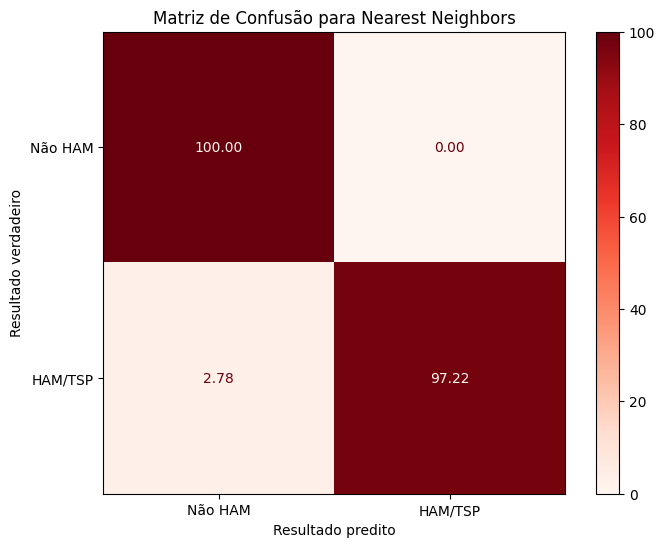

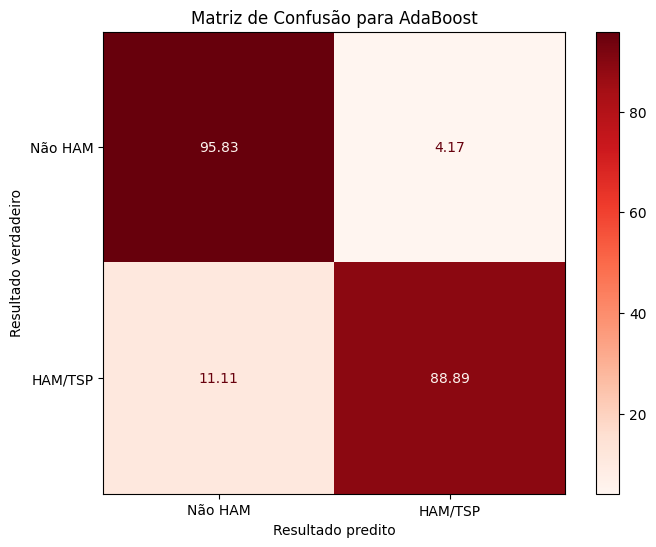

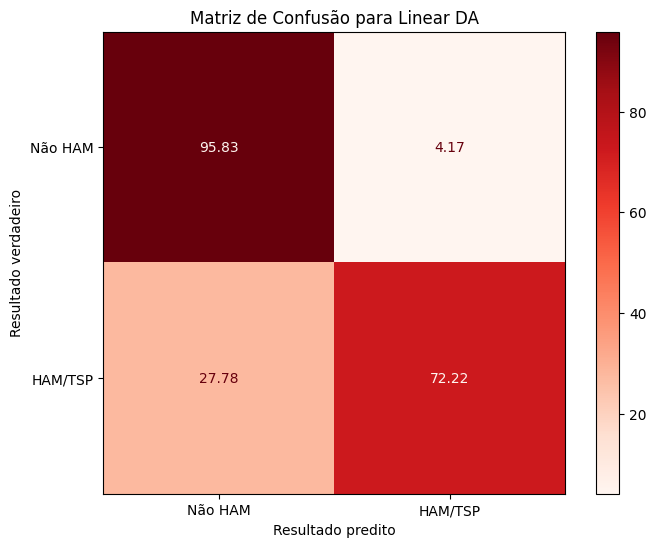

In [10]:
# Define X_test and y_test using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
y_pred = item.predict(X_test)

# Iterate over each classifier and display the confusion matrix
for item, nome in zip(classifiers, names):
    # Retrain the classifier
    item.fit(X, y)

    # Make predictions on the test set
    y_pred = item.predict(X_test)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Convert the confusion matrix into percentages
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Plot the confusion matrix with red cmap and percentages
    disp = ConfusionMatrixDisplay(cm_percentage, display_labels=["Não HAM", "HAM/TSP"])

    # Plot the confusion matrix with red cmap and percentages
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(cmap="Reds", ax=ax, values_format='.2f')
    ax.set_title(f'Matriz de Confusão para {nome}')

    # Remove axis titles
    ax.set_ylabel('Resultado verdadeiro')
    ax.set_xlabel('Resultado predito')

    #Save figures
    plt.savefig(f'/content/drive/MyDrive/Mestrado/Códigos_Bioinfo_e_docs_relacionados(menos_Python_colab)/Pós-qualificação/Confusion matrix/Confusion matrix_{nome}.jpeg')
    plt.show()